In [49]:
import torch
import torchvision
import torchvision.transforms as transforms

In [50]:
#torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage
#将其标准化为范围在[-1, 1]之间的张量
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [111]:
trainset = torchvision.datasets.CIFAR10(root='/home/msy/jupyterProjects/data', train=True,transform=transform)#, download=True
trainloader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/msy/jupyterProjects/data', train=False, transform=transform)#,download=True
testloader = torch.utils.data.DataLoader(testset, batch_size=6,
                                         shuffle=False, num_workers=2)

In [112]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [113]:
import matplotlib.pyplot as plt
import numpy as np

In [114]:
def imshow(img):
    img=img/2+0.5 #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
# 随机获取训练图片    
dataiter=iter(trainloader)
images,labels=dataiter.next()

In [115]:
images.size()

torch.Size([6, 3, 32, 32])

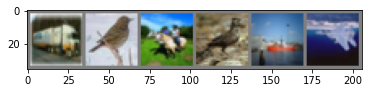

  truck    bird   horse    bird    ship   plane 


In [116]:
#显示图片
imshow(torchvision.utils.make_grid(images))

#打印图片标签
print(''.join('  %5s '%classes[labels[j]] for j in range(6)))

In [117]:
import torch.nn as nn
import torch.nn.functional as F

In [118]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)# in_channels, out_channels，kernel_size, 
        self.pool = nn.MaxPool2d(2, 2)  #  kernel_size, stride, 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # in,out
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 3x32x32->6x28X28->6x14x14
        x = self.pool(F.relu(self.conv2(x))) # 6x14x14->16x10x10->16x5x5
        x = x.view(-1, 16 * 5 * 5)#智能整理成n×16×5×5（即1×16×5×5）but Doesn‘t change tensor layout in memory
        x = F.relu(self.fc1(x)) # 1×16×5×5->1×120
        x = F.relu(self.fc2(x)) #1x120->1*84
        x = self.fc3(x) #1*84->1*10
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [119]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [60]:
for epoch in range(2):
    running_loss=0.0
    for i,data in enumerate(trainloader, 0):
        #get the inputs
        inputs,labels=data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward+backward+optimize
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        #print statistcs
        running_loss +=loss.item()
        if i%2000==1999:
            print('[%d, %5d]loss: %.3f'%(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
    print('Finshed Training')
    

[1,  2000]loss: 2.175
[1,  4000]loss: 1.799
[1,  6000]loss: 1.603
[1,  8000]loss: 1.501
Finshed Training
[2,  2000]loss: 1.423
[2,  4000]loss: 1.360
[2,  6000]loss: 1.324
[2,  8000]loss: 1.294
Finshed Training


In [61]:
PATH='./cifar_net.pth'
torch.save(net.state_dict(),PATH)

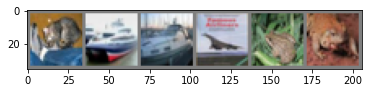

GrounfTruth:   cat  ship  ship plane  frog  frog 


In [120]:
TestDataIter=iter(testloader)
TestImages,TestLabels=TestDataIter.next()
#display the images
imshow(torchvision.utils.make_grid(TestImages))
print('GrounfTruth:',''.join('%5s '% classes[TestLabels[j]] for j in range(6)))

In [121]:
net=Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

In [122]:
outputs.size()

torch.Size([6, 10])

In [123]:
outputs[1]

tensor([ 0.6731, -2.0473,  1.2595,  1.4891,  0.4229,  0.6584, -0.2316,  0.3723,
        -1.7804, -2.4273], grad_fn=<SelectBackward>)

In [124]:
_,predicted=torch.max(outputs,1)
print('Predicted: ',''.join(' %5s '%classes[predicted[j]] for j in range(6)))

Predicted:   truck    cat  horse   bird   ship    car 


In [125]:
#Let us look at how the network performs on the whole dataset.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    
print('Accuracy of the network on the 10000 test images:%d %%' %(100*correct/total))

Accuracy of the network on the 10000 test images:53 %


In [128]:
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _, predicted = torch.max(outputs, 1)
        
        # 从数组的形状中删除单维条目，即把shape中为1的维度去掉
        c=(predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))     

Accuracy of plane : 35 %
Accuracy of   car : 75 %
Accuracy of  bird : 35 %
Accuracy of   cat : 38 %
Accuracy of  deer : 41 %
Accuracy of   dog : 60 %
Accuracy of  frog : 56 %
Accuracy of horse : 62 %
Accuracy of  ship : 78 %
Accuracy of truck : 58 %


In [130]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [131]:
device

device(type='cuda', index=0)

In [132]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)